In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# fairdo
from fairdo.preprocessing import MetricOptimizer
from fairdo.utils.dataset import load_data

## 1. Load Dataset

When using `load_data`, an identifier is passed as a string to return the yielded dataset. This function returns a triple which consists of a dataframe, the label as a string, and a list of protected attributes. Both label and all protected attributes are columns of the returned dataframe.

In [2]:
df, label, protected_attributes = load_data('compas')

Data downloaded.
['Other' 'African-American' 'Caucasian' 'Hispanic' 'Native American'
 'Asian']
African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64
(7214, 8)


In [3]:
df.head()

,race,priors_count,two_year_recid,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M
0,5,0,0,0,1,0,1,0
1,0,0,1,1,0,0,1,0
2,0,4,1,0,0,1,1,0
3,0,1,0,0,0,1,1,0
4,5,2,0,1,0,0,1,0


In [4]:
protected_attributes

['race']

In [5]:
label

'two_year_recid'

## 2. Data Removal As Bias Mitigation

Remove data points that might influence the dataset in a discriminatory way. Specify a portion of the dataset that the user at least wants to keep. Algorithm can stop earlier if discrimination threshold is already satisfied, resulting in a larger dataset than set.

In [6]:
# Initialize MetricOptimizer
# Keep 75\% of the whole dataset
preproc = MetricOptimizer(frac=0.75,
                          protected_attribute=protected_attributes[0],
                          label=label)

In [7]:
# Create pre-processing instance
preproc = preproc.fit(df)
# Remove samples to yield a fair dataset
df_fair = preproc.transform()

### 2.1 Compare Fairness/Discrimination

Here, we measure the discrimination by using the absolute value of statistical disparity. `y` corresponds to the label and `z` corresponds the protected attribute. Both parameters expect array-like types.

In [8]:
from fairdo.metrics import statistical_parity_abs_diff

In [9]:
y_fair = df_fair[label]
z_fair = df_fair[protected_attributes].to_numpy().flatten() # expects 1d array
y = df[label]
z = df[protected_attributes].to_numpy().flatten() # expects 1d array

In [10]:
discrimination_fair = statistical_parity_abs_diff(y=y_fair, z=z_fair)
discrimination_orig = statistical_parity_abs_diff(y=y, z=z)

In [11]:
print(f'The original dataset has a statistical disparity (absolute) value of: {discrimination_orig}')
print(f'The pre-processed fair dataset has a statistical disparity (absolute) value of: {discrimination_fair}')
print('(Lower is better.)')

The original dataset has a statistical disparity (absolute) value of: 1.8856276310662383
The pre-processed fair dataset has a statistical disparity (absolute) value of: 0.09804732912604375
(Lower is better.)


Discrimination was largely reduced by only removing 25\% of the samples.

## 3. Synthetic Fair Data Generation

Use synthetic data to achieve fairness. This algorithm randomly chooses points from a set of synthetic datapoints and merges them with the original data to achieve fairness. This way, the original data is not removed.

In [12]:
# Initialize MetricOptimizer
# Doubling the dataset's size
preproc = MetricOptimizer(frac=2,
                          protected_attribute=protected_attributes[0],
                          label=label)

In [13]:
# Create pre-processing instance
preproc = preproc.fit(df)
# Remove samples to yield a fair dataset
df_fair = preproc.transform()

### 3.1 Compare Correlation Matrices

We may be interested in checking how the features correlate with eachother. This way, it is possible to evaluate whether the fair dataset resembles the original dataset.

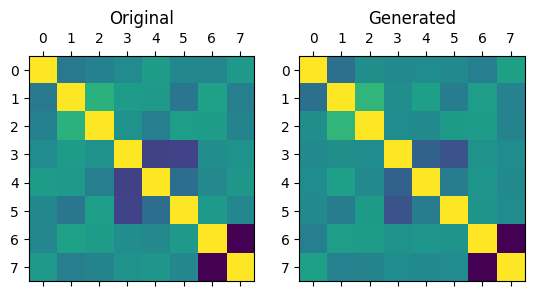

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.matshow(df.corr())
ax1.title.set_text("Original")

ax2.matshow(df_fair.iloc[-150::].corr())
ax2.title.set_text("Generated")

In [15]:
np.linalg.norm(df.corr() - df_fair.corr())

0.3581458248913403

Plots look similar and the L2 norm of the difference of the correlation matrices is very low.

### 3.2 Compare Fairness/Discrimination of Generated Data (includes original)

In [16]:
y_fair = df_fair[label]
z_fair = df_fair[protected_attributes].to_numpy().flatten() # expects 1d array
y = df[label]
z = df[protected_attributes].to_numpy().flatten() # expects 1d array

In [17]:
discrimination_fair = statistical_parity_abs_diff(y=y_fair, z=z_fair)
discrimination_orig = statistical_parity_abs_diff(y=y, z=z)

In [18]:
print(f'The original dataset has a statistical disparity (absolute) value of: {discrimination_orig}')
print(f'The pre-processed fair dataset has a statistical disparity (absolute) value of: {discrimination_fair}')
print('(Lower is better.)')

The original dataset has a statistical disparity (absolute) value of: 1.8856276310662383
The pre-processed fair dataset has a statistical disparity (absolute) value of: 0.0027526458477828974
(Lower is better.)


While keeping the original data, adding synthetic data can make the overall dataset much fairer.